In [1]:
import re
import pandas as pd
import nltk
import multiprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
# nltk.download('stopwords') ----> udkommenter denne linje, hvis du ikke har nltk installeret
# nltk.download('punkt') ----> udkommenter denne linje, hvis du ikke har nltk installeret
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("995,000_rows.csv", dtype="string")

print("the shape of the data is: ", data.shape)

# print(data.head())

the shape of the data is:  (995000, 17)


{'nationalreview.com': 37377, 'beforeitsnews.com': 91468, 'dailycurrant.com': 5, 'nytimes.com': 176144, 'infiniteunknown.net': 1228, 'online.wsj.com': 208, 'dailykos.com': 77640, 'blackagendareport.com': 97, 'sputniknews.com': 37229, 'www.politico.com': 183, 'abovetopsecret.com': 27947, 'blackgenocide.org': 5, 'express.co.uk': 55983, 'thefifthcolumnnews.com': 1768, 'teapartytribune.com': 3302, 'www.businessinsider.com': 778, 'shadowproof.com': 3483, 'thenewamerican.com': 3059, 'libertyunyielding.com': 2088, 'investmentwatchblog.com': 8042, 'www.ammoland.com': 11129, 'presstv.com': 4167, 'www.newsmax.com': 12688, 'breitbart.com': 7018, 'twitchy.com': 5361, 'theduran.com': 1546, 'awm.com': 20, 'flyheight.com': 296, 'jihadwatch.org': 1455, 'barenakedislam.com': 234, 'fellowshipoftheminds.com': 2951, 'rawstory.com': 7059, 'indianexpress.com': 1346, 'coed.com': 1254, 'theshovel.com.au': 52, 'dailycaller.com': 7814, 'lifenews.com': 5590, 'www.amazon.com': 5831, 'ca.reuters.com': 672, 'thepeo

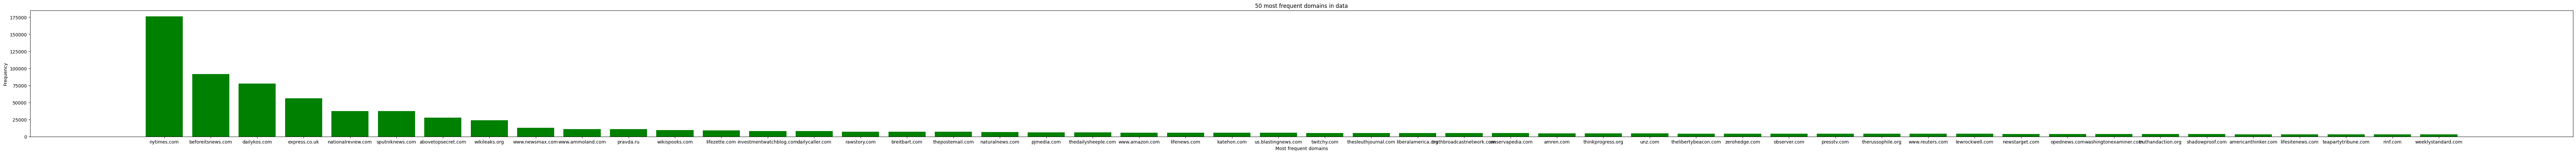

In [3]:
# creating dictionary with domains as key and their frequency as value
domain_dict = {}

for (domain) in data['domain']:
    if domain not in domain_dict.keys():
        domain_dict[domain] = 1
    else:
        domain_dict[domain] = domain_dict[domain] + 1

print(domain_dict)

# sorting dictionary with largest value first
sorted_domain_dict = dict(sorted(domain_dict.items(), key=lambda x:x[1], reverse=True))

print(sorted_domain_dict)

# creating plot  
words = list(sorted_domain_dict.keys())[:50]
freq = list(sorted_domain_dict.values())[:50]

fig = plt.figure(figsize = (100, 5))
 
plt.bar(words, freq, color ='green')
 
plt.xlabel("Most frequent domains")
plt.ylabel("Frequency")
plt.title("50 most frequent domains in data")
plt.show()

In [8]:
# cleaning content

def cleanText(text):
    if not isinstance(text, str):  
        return str(text)
    
    # lower case
    text = text.lower()

    # should not contain multiple spaces, tabs or newlines
    text = re.sub(r'\s+', ' ', text)

    # date and time stuff
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?\s*(?:of\s+)?(January|February|March|April|May|June|July|August|September|October|November|December)\b', '<DATE>', text)
    # text = re.sub(r'r"([a-zA-Z]{3}\s\d{1,2}\s\d{4})"', '<DATE>', text, flags=re.IGNORECASE)
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?(?: of)?(?: (?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?))(?: (\d{4}|\d{2}))?\b', '<DATE>', text)
    # text = re.sub(r'\b(?:the )?(\d{1,2})(?:st|nd|rd|th)?(?: of)?(?: (?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?|Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?))(?: (\d{4}|\d{2}))?\b', '<DATE>', text)

    # replace dates with <DATE>
    #  january 18, 2018. jan 18, 2018. 2018-01-18
    date_pattern = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2}(?:,\s+|\s+)\d{4}\b|\b\d{4}-\d{2}-\d{2}\b'

    # date_pattern = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\s+\d{1,2},\s+\d{4}\b|\b\d{4}-\d{2}-\d{2}\b'
    text = re.sub(date_pattern, '<DATE>', text)
    # nov. 5
    date_pattern2 = r'\b(?:jan(?:uary)?|feb(?:ruary)?|mar(?:ch)?|apr(?:il)?|may|jun(?:e)?|jul(?:y)?|aug(?:ust)?|sep(?:tember)?|oct(?:ober)?|nov(?:ember)?|dec(?:ember)?)\.\s+\d{1,2}\b'
    text = re.sub(date_pattern2, '<DATE>', text)

    # text = re.sub(r'\b(?:\d{1,2}[-/th|st|nd|rd\s]*)?(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)(?:\s*(?:\d{1,2}[-/th|st|nd|rd\s]*))?(?:\s*(?:\d{4}|\d{2}))?\b', '<DATE>', text)

    # replace numbers with <NUM>
    text = re.sub(r'\d+', '<NUM>', text)

    # replace urls with <URL>
    text = re.sub(r'(http|https)://[^\s]*', '<URL>', text)

    # replace emails with <EMAIL>
    text = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b', '<EMAIL>', text)

    # remove various punctuations
    text = re.sub(r'[^\w\s]', '', text)

    return text

def clean_parts(data):
    data['content'] = data['content'].apply(cleanText)
    return data

# cleaning content
data_cleaned = clean_parts(data)

In [11]:
# tokenizing content
tokens1 = data_cleaned['content'][:248750].apply(nltk.word_tokenize)
tokens2 = data_cleaned['content'][-(497500 + 248750):497500].apply(nltk.word_tokenize) 
tokens3 = data_cleaned['content'][497500:497500+248750].apply(nltk.word_tokenize)
tokens4 = data_cleaned['content'][-248750:].apply(nltk.word_tokenize)
tokens1.append(tokens2)
tokens1.append(tokens3)
tokens1.append(tokens4)
tokens = tokens1

# removing stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = []

for list in tokens:
    filtered_words = []
    for w in list:
        if w not in stop_words:
            filtered_words.append(w)
    filtered_tokens.append(filtered_words)

MemoryError: 

In [ ]:
vocabulary = []
vocabulary_with_stopwords = []

for list in tokens:
    for w in list:
        if w not in vocabulary_with_stopwords:
            vocabulary_with_stopwords.append(w)


for list in filtered_tokens:
    for w in list:
        if w not in vocabulary:
            vocabulary.append(w)


print("Vocabulary with stopwords included:\n")
print(vocabulary_with_stopwords)
print("Length of vocabulary with stopwords included: " + str(len(vocabulary_with_stopwords)) + "\n")
print("Vocabulary with stopwords excluded:\n")
print(vocabulary)
print("Length of vocabulary with stopwords excluded: " + str(len(vocabulary)))
print("Reduction in vocabulary length: " + str(len(vocabulary_with_stopwords) - len(vocabulary)))